## Importing necessary libraries

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,RNN,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pickle
import shutil
from IPython.display import Image
import io
from nltk.translate.gleu_score import sentence_gleu
from nltk.translate.bleu_score import sentence_bleu

In [2]:
# !wget --header="Host: doc-0c-2g-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_p1fg4b07u3raciih5atnsbt7sdk7uaqn_nonce=8on2sr8dajkka" --header="Connection: keep-alive" "https://doc-0c-2g-docs.googleusercontent.com/docs/securesc/k57aefr9gh8rpf3r9srcg2pseasqmf46/svjffscs83afkaq7mv2ujiuk8pfnnul9/1618038375000/04473764286494136551/04473764286494136551/1ZQzu5rtBPhZHud16ZP7CK6WZQTg8Zkyd?e=download&authuser=0&nonce=8on2sr8dajkka&user=04473764286494136551&hash=6jhgjr5j9af6299evtk7uoon2m1nehgp" -c -O 'fasttext.zip'
# !unzip 'fasttext.zip'

## Making data model ready

In [2]:
## loading train, test and CV data
train = pd.read_csv("train_attention.csv")
cv = pd.read_csv("cv_attention.csv")
test = pd.read_csv("test_attention.csv")

In [4]:
# code reference https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring
# loading saved tokenizer
with open("tokenizer_incorr_word_attention.pickle","rb") as temp1:
    tokenizer_incorr = pickle.load(temp1)
    
with open("tokenizer_corr_inp_word_attention.pickle","rb") as temp2:
    tokenizer_corr_inp = pickle.load(temp2)
    
with open("tokenizer_corr_out_word_attention.pickle","rb") as temp3:
    tokenizer_corr_out = pickle.load(temp3)

Tokenizing senetence for feeding to encoder

In [5]:
# tokenizer_incorr = Tokenizer(filters="",lower=False)
# tokenizer_incorr.fit_on_texts(train["incorrect"].values)
incorr_train = np.array(tokenizer_incorr.texts_to_sequences(train["incorrect"].values))
print("vocab size of incorrrect sentences is",len(tokenizer_incorr.word_index))

vocab size of incorrrect sentences is 52613


Tokenizing senetence for feeding to decoder as inpput

In [6]:
# tokenizer_corr_inp = Tokenizer(filters="",lower=False)
# tokenizer_corr_inp.fit_on_texts(train["correct_inp"].values)
corr_train_inp = np.array(tokenizer_corr_inp.texts_to_sequences(train["correct_inp"].values))
print("vocab size of corrrect sentences is",len(tokenizer_corr_inp.word_index))

vocab size of corrrect sentences is 47126


Tokenizing senetence which will be output of decoder

In [7]:
# tokenizer_corr_out = Tokenizer(filters="",lower=False)
# tokenizer_corr_out.fit_on_texts(train["correct_out"].values)
corr_train_out = np.array(tokenizer_corr_out.texts_to_sequences(train["correct_out"].values))
print("vocab size of corrrect sentences is",len(tokenizer_corr_out.word_index))

vocab size of corrrect sentences is 47126


In [8]:
## #save keras tokenizer

# with open("tokenizer_incorr_word_attention.pickle","wb") as temp1:
#     pickle.dump(tokenizer_incorr,temp1)
    
# with open("tokenizer_corr_inp_word_attention.pickle","wb") as temp2:
#     pickle.dump(tokenizer_corr_inp,temp2)
    
# with open("tokenizer_corr_out_word_attention.pickle","wb") as temp3:
#     pickle.dump(tokenizer_corr_out,temp3)

Padding train, cv, test data

In [9]:
incorr_train = np.array(pad_sequences(incorr_train,maxlen=25,padding="post",truncating='post'))
corr_train_inp = np.array(pad_sequences(corr_train_inp,maxlen=25,padding="post",truncating='post'))
corr_train_out = np.array(pad_sequences(corr_train_out,maxlen=25,padding="post",truncating='post'))

#### Using pretrained fasttext embeddings

In [11]:
# !wget --header="Host: dl.fbaipublicfiles.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://fasttext.cc/" --header="Cookie: __cfduid=d0995b9a675be50a9c5a78dbf19cacc201617113683" --header="Connection: keep-alive" "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip" -c -O 'wiki-news-300d-1M.vec.zip'
# !unzip "wiki-news-300d-1M.vec.zip"

In [13]:
##code taken from https://fasttext.cc/docs/en/crawl-vectors.html

# def load_vectors(fname):
#     """
#     this function tales name of zipped file as input and returns word and corresponging embeddings as dictionary
#     """
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     data = {}
#     for line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = map(float, tokens[1:])
#     return data
# dic = load_vectors("wiki-news-300d-1M.vec")

In [ ]:
##save dictionary to disk
# with open("dic_atention.pickle","wb") as temp1:
#     pickle.dump(dic,temp1)

In [6]:
# with open("dic_atention.pickle","rb") as temp1:
#     embeddings_index = pickle.load(temp1)

In [11]:
## prepare embedding matrix 1

# embedding_matrix1 = np.zeros((52614, 300))
# for word, i in tokenizer_incorr.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix1[i] = list(embedding_vector)
#     else:
#         print("hi")

## save embedding matrix 1 to disk
#np.save("incorr_matrix",embedding_matrix1)

In [10]:
embedding_matrix1 = np.load("incorr_matrix.npy")

In [13]:
## prepare embedding matrix 2

# embedding_matrix2 = np.zeros((47127, 300))
# for word, i in tokenizer_corr_inp.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix2[i] = list(embedding_vector)
#     else:
#         print(word,i)
        
# ## save embedding matrix 2 to disk
# np.save("corr_matrix",embedding_matrix2)

In [11]:
embedding_matrix2 = np.load("corr_matrix.npy")

#### Defining model artchitecture

In [13]:
# code taken from attention mechanism assignment

############################## Encoder class #############################################################

class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        
        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=300, input_length=input_length,
                           mask_zero=True,name="embedding_layer_encoder", weights=[embedding_matrix1], trainable=False)
        self.lstmcell = tf.keras.layers.LSTMCell(lstm_size)
        self.encoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)


    def call(self,input_sequence,states):

        output1 = self.embedding(input_sequence)
        enco_output, enco_state_h, enco_state_c = self.encoder_lstm(output1, initial_state=states)
        return enco_output, enco_state_h, enco_state_c

    
    def initialize_states(self,batch_size):

        initial_hidden_state = tf.zeros([batch_size,self.lstm_size])
        initial_cell_state = tf.zeros([batch_size,self.lstm_size])
        
        return [initial_hidden_state,initial_cell_state]
    
############################## Decoder class #############################################################
    
class Decoder(tf.keras.layers.Layer):

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=out_vocab_size, output_dim=300, input_length=input_length,
                           mask_zero=True,name="embedding_layer_encoder", weights=[embedding_matrix2], trainable=False)
        self.lstmcell = tf.keras.layers.LSTMCell(lstm_size)
        self.decoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)

    def call(self,target_sequence,initial_states):

        output2 = self.embedding(target_sequence)
        deco_output, deco_state_h, deco_state_c = self.decoder_lstm(output2, initial_state=initial_states)
      
        return deco_output, deco_state_h, deco_state_c
    
##############################encoder decoder class#############################################################
    
qw_state = 0
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,inp_vocab_size,out_vocab_size,embedding_size,lstm_size,input_length,batch_size,*args):
        
        super().__init__()
        self.encoder = Encoder(inp_vocab_size,embedding_size,lstm_size,input_length)
        #print("output vocab size in encoder decoder class",out_vocab_size)
        self.decoder = Decoder(out_vocab_size,embedding_size,lstm_size,input_length)
        self.dense   = Dense(out_vocab_size)#, activation='softmax')
        self.batch = batch_size
    
    
    def call(self,data,*args):
        
        input,output = data[0], data[1]
        # initializing initial states of encoder
        l = self.encoder.initialize_states(self.batch)
        qw_state = l
        encoder_output,encoder_final_state_h,encoder_final_state_c = self.encoder(input,l)
        m = list((encoder_final_state_h,encoder_final_state_c))
        decoder_output,decoder_final_state_h,decoder_final_state_c = self.decoder(output,m)
        qw_output = self.dense(decoder_output)
        #print("FINAL OUTPUT SHAPE",qw_output.shape)
        return qw_output

In [14]:
inp_vocab_size = 52614
out_vocab_size = 47127
embedding_dim=300
input_length=25
lstm_size=64
batch_size=1024
#model = Encoder_decoder(inp_vocab_size,out_vocab_size,embedding_dim,lstm_size,input_length,batch_size)

optimizer = tf.keras.optimizers.Adam()
#defining custom loss function which will not consider loss for padded zeroes
# code taken from attention assignment
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
#model.compile(optimizer=optimizer,loss=loss_function)

In [19]:
##Load the TensorBoard notebook extension
# import datetime
# %load_ext tensorboard
# !rm -rf ./logs/

Train the model

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(x=[incorr_train,corr_train_inp],y=corr_train_out, epochs=50,batch_size=1024,callbacks=[tensorboard_callback]

Epoch 1/50
352/352 [==============================] - 204s 571ms/step - loss: 2.0137
Epoch 2/50
352/352 [==============================] - 201s 570ms/step - loss: 1.5214
Epoch 3/50
352/352 [==============================] - 201s 570ms/step - loss: 1.3685
Epoch 4/50
352/352 [==============================] - 201s 570ms/step - loss: 1.2355
Epoch 5/50
352/352 [==============================] - 201s 570ms/step - loss: 1.1305
Epoch 6/50
352/352 [==============================] - 201s 570ms/step - loss: 1.0519
Epoch 7/50
352/352 [==============================] - 201s 570ms/step - loss: 0.9959
Epoch 8/50
352/352 [==============================] - 201s 570ms/step - loss: 0.9423
Epoch 9/50
352/352 [==============================] - 201s 570ms/step - loss: 0.9065
Epoch 10/50
352/352 [==============================] - 201s 570ms/step - loss: 0.8728
Epoch 11/50
352/352 [==============================] - 201s 570ms/step - loss: 0.8466
Epoch 12/50
352/352 [==============================] - 201s 570

#### save the trained model

In [16]:
# code taken from https://colab.research.google.com/drive/172D4jishSgE3N7AO6U2OKAA_0wNnrMOq#scrollTo=mJqOn0snzCRy
#model.save_weights('enco_dec_word_fasttext_trained1', save_format='tf')

##relaod saved model
model = Encoder_decoder(inp_vocab_size,out_vocab_size,embedding_dim,lstm_size,input_length,batch_size)
model.compile(optimizer=optimizer,loss=loss_function)
model.train_on_batch([incorr_train[:1024],corr_train_inp[:1024]],corr_train_out[:1024])
model.load_weights('enco_dec_word_fasttext_trained1_old')

In [17]:
model.summary()

Model: "encoder_decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  15877640  
_________________________________________________________________
decoder_1 (Decoder)          multiple                  14231540  
_________________________________________________________________
dense_1 (Dense)              multiple                  3063255   
Total params: 33,172,435
Trainable params: 3,250,135
Non-trainable params: 29,922,300
_________________________________________________________________


Defining predict function

In [18]:
#code taken from attention mechanism assignment
corr_dict = tokenizer_corr_out.word_index
inv_corr = {v: k for k, v in corr_dict.items()}

def predict(input_sentence):
    """
    this function takes incorrect input sentences s input and retirns correct sentences
    """
    input_sentence = tokenizer_incorr.texts_to_sequences([input_sentence])
    initial_hidden_state = tf.zeros([1,64])
    initial_cell_state = tf.zeros([1,64])
    qwst = [initial_hidden_state,initial_cell_state]
    pred_total = []
    enc_output, enc_state_h, enc_state_c = model.layers[0](np.expand_dims(input_sentence[0],0),qwst)
    states_values = [enc_state_h, enc_state_c]
    pred = []
    sentence = []
    cur_vec = np.array([[1]])
    for i in range(40):
        dec_output, dec_state_h, dec_state_c = model.layers[1](cur_vec,states_values)
        infe_output=model.layers[2](dec_output)
        states_values = [dec_state_h, dec_state_c]
        cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
        if inv_corr[cur_vec[0][0]] == '@':
            break
        pred.append(cur_vec[0][0])
    for i in pred:
        sentence.append(inv_corr[i])
    return " ".join(sentence)

#### GLUE Score on test data

In [23]:
gleu_score_test = 0
bleu_score_test = 0
length = 1000

for i in range(length):
    reference = [test["correct"].values[i:i+1][0].split()]
    candidate = predict(test["incorrect"].values[i:i+1][0]).split()
    gleu_score_test = gleu_score_test + sentence_gleu(reference, candidate)
    #bleu_score_test = bleu_score_test + sentence_bleu(reference, candidate)
    #print(gleu_score,bleu_score)
print("Final GLEU Score on Test data are",gleu_score_test/length)

Final GLEU Score on Test data are 0.2624148926941346


#### Prediting results on train data

In [32]:
#predicted sentences
for i in train["incorrect"].values[:10]:
  print(predict(i))

I got up to Lang because I want to improve my English and I can learn Japanese .
So I decided that I kept going to buy a promise to forget .
The island is the convenience of the restaurants , which is also a hot feature of the fridge , and use the Japanese paper .
My dog and I went to my parents !
Today I received one of my friend from the email .
I know that the radioactivity is dangerous .
So , I wonder if there are such a surprise , but I 'm interested in the world .
And the lecture the students asked the same system
But I must take a TOEIC test today .
The office is on the day ,


In [20]:
#actual sentences
train["correct"].values[:10]

array(['I signed up on Lang   because I want to improve my English and I want learn Spanish .',
       "So I ended up buying stuff I did ' nt expect to buy .",
       ' MINI STOP  is one of the popular convenience stores in Japan and sells several delicious ice creams .',
       'My dog and I went to see my mom off  !',
       'Today I received a message from one of my Lang   friends .',
       'I know that radioactivity is dangerous .',
       'So , I wonder if there are surprising things eaten or so in your country .',
       'And the lecturer told the students that they were expected to use their',
       'But I had to take the TOEIC today .',
       'The office is locked on weekends .'], dtype=object)

#### Prediting results on CV data

In [23]:
for i in cv["incorrect"].values[:10]:
  print(predict(i))

You can give him with a native speaker , because my family and a kind of the teacher would be very useful .
Today I went to a public service center of a phone .
My husband and I go shopping every day in my town .
How do you study language ?
And the Japanese teacher speaks it !
On a Sunday , my favorite name 's wedding for Japan and took a short letter .
In addition to Japan , it caused many tests .
I have to write a few minutes this time .
I watched TV about the movie .
I did not know that I always do my writing the way I was not a nightmare or


In [24]:
#actual sentences
cv["correct"].values[:10]

array(['You can persuade him  her with your wonderful graphic skills and a new logical skill .',
       "Today I went to my local government 's service desk",
       'My husband and I go grocery shopping every weekend .',
       'How do you study other languages ?',
       'And the sales clerks speak Japanese very fluently !',
       'In an English dictionary ,  th wedding anniversary  is called a  linen wedding . ',
       'In addition to it , Tohoku radiation problems occurred .',
       'I have little time to write this post .',
       'I watched TV about the moon .',
       'I did not write anything for a long time because I always forget my password : '],
      dtype=object)

#### Prediting results on Test data

In [25]:
#predicted sentences
for i in test["incorrect"].values[:10]:
  print(predict(i))

You can be fun here , too .
For example , I 'm writing , and grammar , and I can use the course .
Some of it caused some things .
I read a weekly entries in a week .
Today , I saw the rainbow !
and the restaurant , and the fish 's cut on the top . .
Wednesday is not the best because of the USA and not to watch the most of the soccer program in Japan .
The speaking speaking the most of the military system is not in the field and I need to move in the tree .
I hope that I have to make a lot of advice , please explain me this diary .
I installed a software on the th .


In [26]:
#actual sentences
test["correct"].values[:10]

array(['You can have fun there , too .',
       'For that , I should study grammar , words and phrases .',
       'Some libraries caused it .', 'I read  magazines per week .',
       'Today , I saw a rainbow !',
       'restaurant has eel and avocado rolls . . .',
       'Mondays are the best because it focuses on football , not only the J league but also overseas leagues .',
       'The education system of America is not top  down but bottom  up .',
       'I have hoped that you could help me with this challenge :  I usually have a lot of grammar errors .',
       'On my computer , I installed a Shogi application .'], dtype=object)

In [24]:
## save tensorflow logs to disk
#shutil.make_archive("enc_dec_fasttext_tensorboard","zip","logs")

#### Plotting tensorboard plots

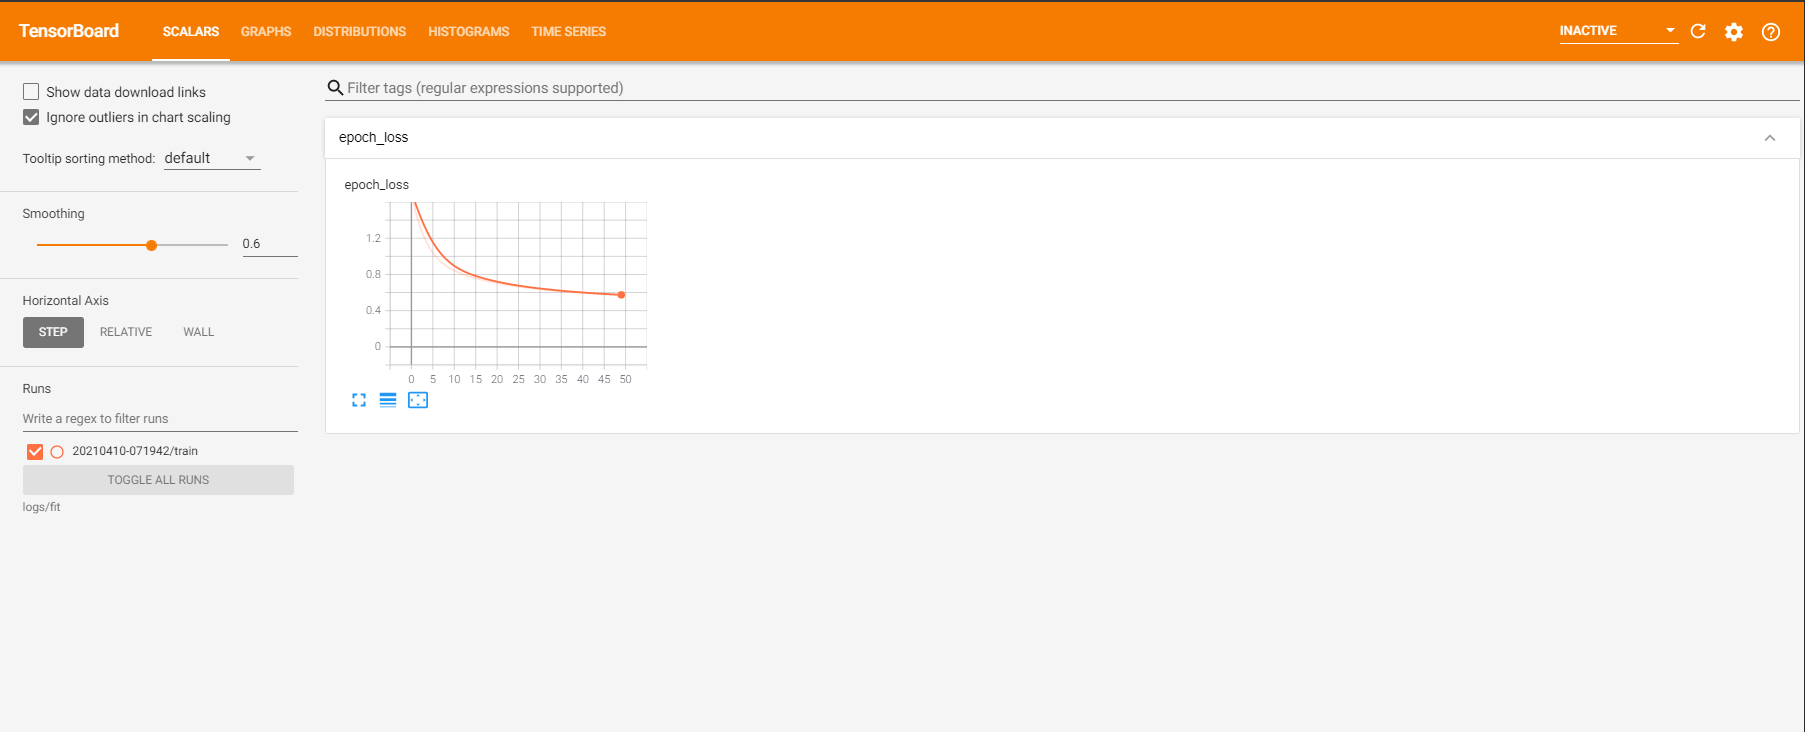

In [28]:
Image(filename='encoder_decoder_fasttext_1.png')

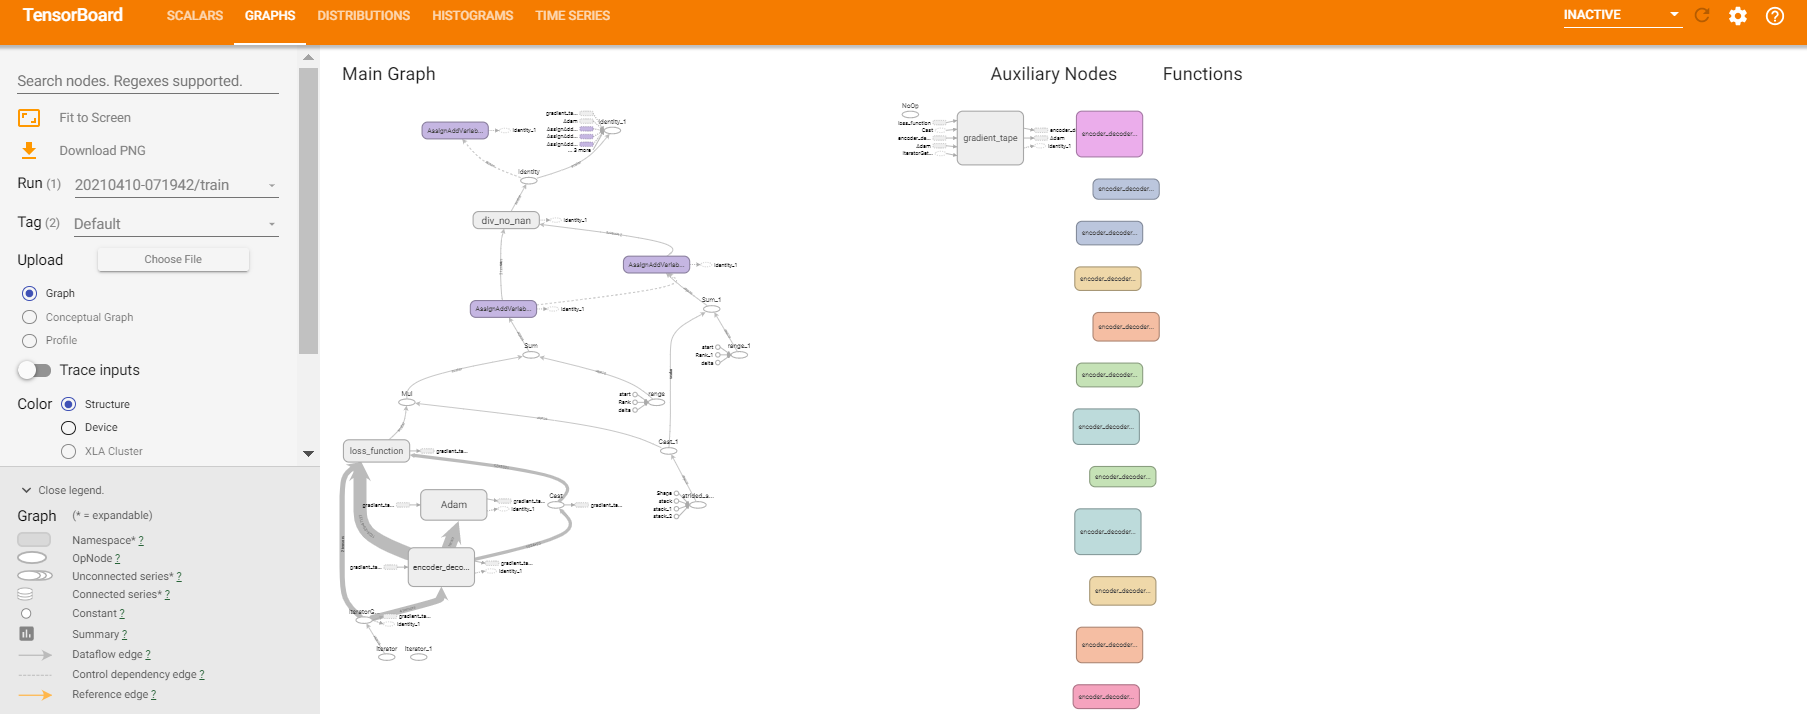

In [29]:
Image(filename='encoder_decoder_fasttext_2.png')

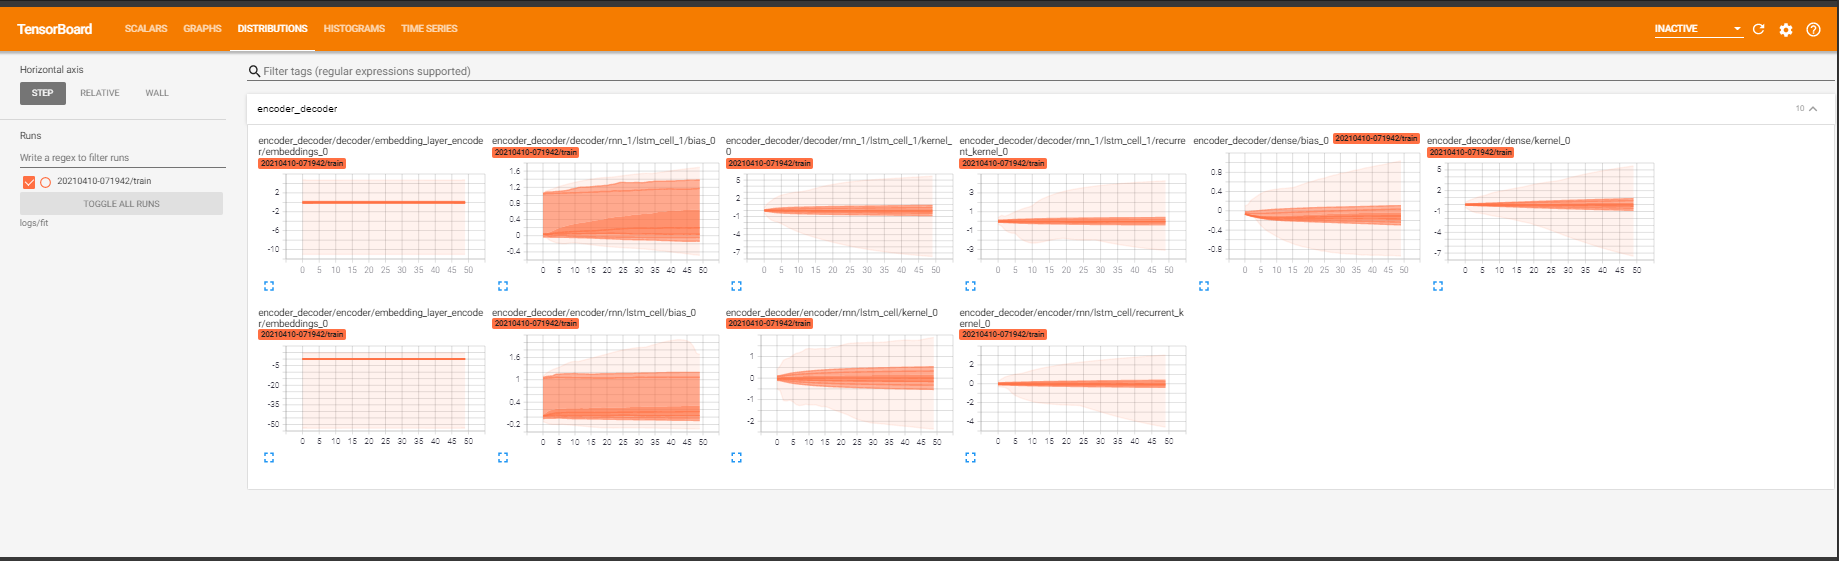

In [30]:
Image(filename='encoder_decoder_fasttext_3.png')

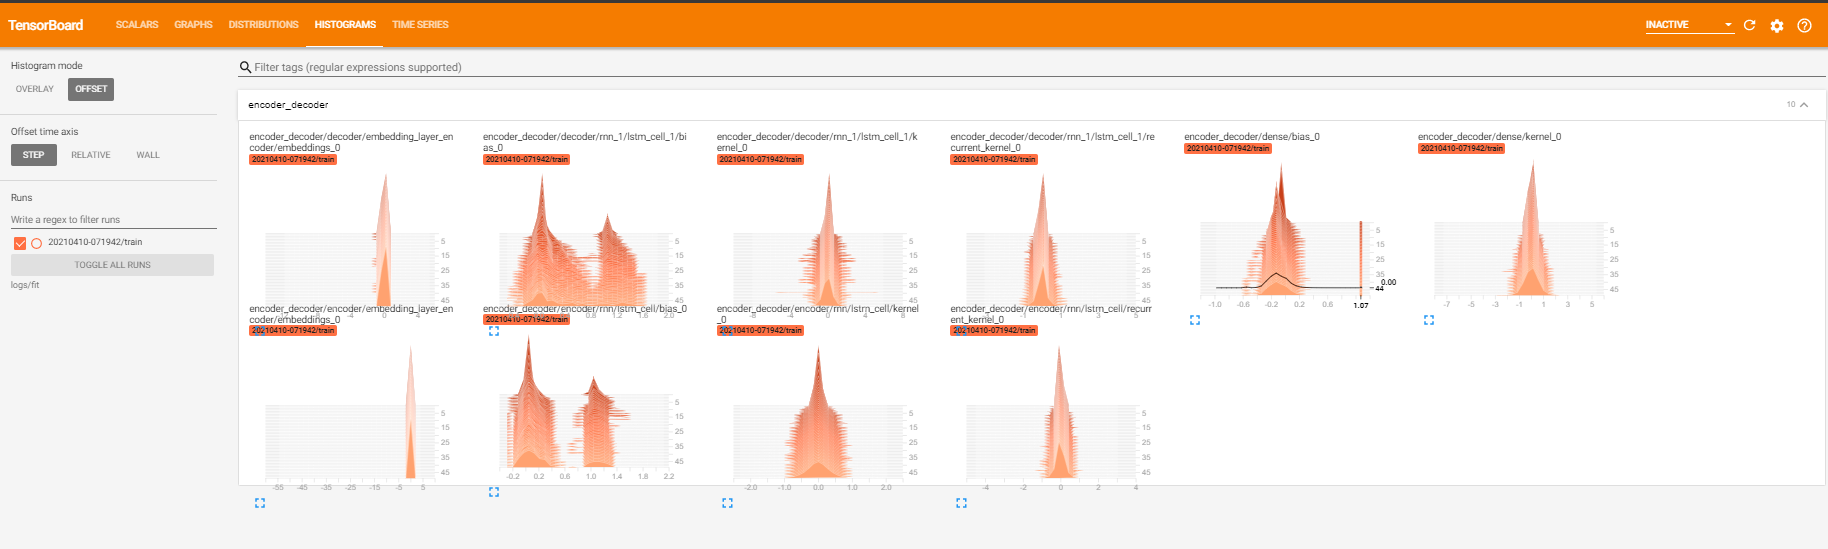

In [31]:
Image(filename='encoder_decoder_fasttext_4.png')